In [1]:
import tensorflow as tf
import tflearn.datasets.oxflower17 as oxflower17
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.cm as cm

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
config = ConfigProto()
config.allow_soft_placement=True
config.gpu_options.per_process_gpu_memory_fraction=0.7
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

https://www.robots.ox.ac.uk/~vgg/data/flowers/17/

In [3]:
(_,y) = oxflower17.load_data(one_hot=False)

In [4]:
path=r'C:\Users\Pomelo Chen\Desktop\Python\17flowers\17flower'
filename = os.listdir(path)
x=np.zeros((len(filename),224, 224,3))
for i in range(len(filename)):
    x[i] = cv2.resize(cv2.imread(path+'\\'+filename[i]),(224,224))

In [5]:
y = np.argmax(y, axis=-1)
x = x.astype('uint8')

In [6]:
vgg16 = tf.keras.applications.VGG16()
vgg16.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________

In [7]:
vgg16_extract = tf.keras.models.Model(vgg16.input, vgg16.get_layer('block5_pool').output)

vgg16_extract.trainable = False
vgg16_extract.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
x_feat = vgg16_extract.predict(x)
des    = np.reshape(x_feat, (-1,512))

In [9]:
x_feat.shape

(1360, 7, 7, 512)

In [10]:
des.shape

(66640, 512)

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *

In [12]:
inputs = Input((7,7,512), name = 'input_')
X = GlobalAveragePooling2D(name = 'gap')(inputs)
outputs = Dense(17, activation = 'softmax', name = 'outputs')(X)

clf = Model(inputs,  outputs)
clf.compile(optimizer = Adam(1e-4), loss = SparseCategoricalCrossentropy(), metrics=['accuracy'])
clf.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ (InputLayer)          [(None, 7, 7, 512)]       0         
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 512)               0         
_________________________________________________________________
outputs (Dense)              (None, 17)                8721      
Total params: 8,721
Trainable params: 8,721
Non-trainable params: 0
_________________________________________________________________


In [13]:
clf.fit(x_feat, y,
       epochs=400,
       shuffle=True,
       batch_size = 20,
       verbose = 0)

In [14]:
from sklearn.metrics import accuracy_score
y_pred = np.argmax(clf.predict(x_feat), axis=-1)
print(accuracy_score(y,y_pred))

0.9345588235294118


In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(des)
P   = pca.transform(des)

In [16]:
P_ = np.reshape(P,(1360,7,7))

In [17]:
for i in range(P_.shape[0]):
    L = np.min(P_[i])
    U = np.max(P_[i])
    P_[i] = (P_[i]-L)/(U-L)  

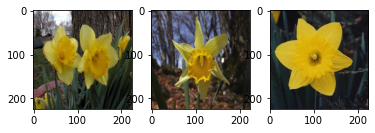

In [18]:
plt.subplot(1,3,1)
plt.imshow(x[0][:,:,::-1])
plt.subplot(1,3,2)
plt.imshow(x[1][:,:,::-1])
plt.subplot(1,3,3)
plt.imshow(x[5][:,:,::-1])

In [19]:
P_re = np.zeros((1360,224,224))
for i in range(P_.shape[0]):
    P_re[i] = cv2.resize(P_[i], (224,224))

In [20]:
def jetheatmap(heatmap):
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    #jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = cv2.resize(jet_heatmap,(heatmap.shape[1], heatmap.shape[0]))
    
    return (jet_heatmap*255).astype('int')

In [21]:
def cascade(index):
    plt.imshow((0.5*(jetheatmap(P_re[index])+x[index])).astype('int'))

In [22]:
def cascade5(index):
    for i in range(5):
        fig, ax = plt.subplots(sharex='col',sharey='row',figsize=(25,25))
        fig.subplots_adjust(hspace=0.1, wspace=0)
        plt.subplot(1,5,i+1)
        cascade(index+i)

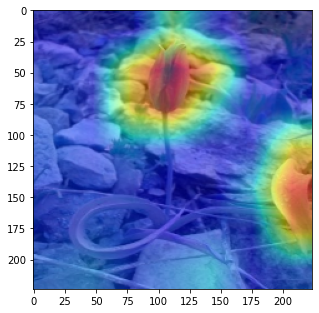

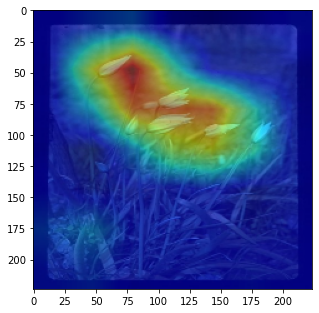

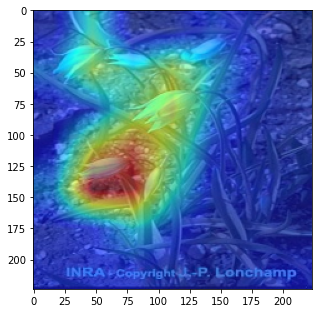

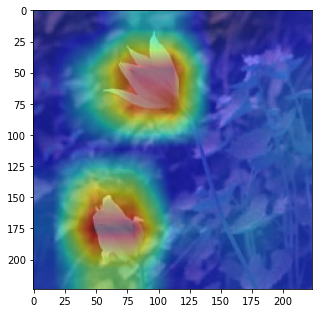

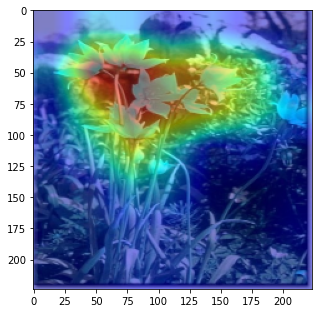

In [23]:
cascade5(600)

Compare with CAM

In [94]:
def CAM(img, label, model = clf, last_conv_name = 'input_', output_layer_name = 'outputs'):
    img = np.reshape(img,(1,224,224,3))
    img_feat = vgg16_extract.predict(img)[0]

    output_layer = model.get_layer(output_layer_name)
    weights = output_layer.get_weights()[0]
    label_weights = weights[:,label]
  
    heatmap = np.zeros(img_feat.shape[:-1])
    for i in range(label_weights.shape[0]):
        heatmap += label_weights[i]*img_feat[:,:,i]
    heatmap = cv2.resize(heatmap, (224,224))
    heatmap = (heatmap-np.min(heatmap))/(np.max(heatmap)-np.min(heatmap))
    heatmap = np.uint8(255 * heatmap)
    
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    return jet_heatmap

In [97]:
def draw_cam(index, img_array = x, label = y):
    n=1
    for i in range(n):
        heatmap = CAM(img_array[index+i], label[index+i], clf, 'input_', 'outputs')
        heatmap = (255*heatmap).astype('int')
        fig, ax = plt.subplots(sharex='col',sharey='row',figsize=(25,25))
        fig.subplots_adjust(hspace=0.1, wspace=0)
        plt.subplot(1,5,i+1)
        superimpose = heatmap + img_array[index+i][:,:,::-1]
        plt.imshow((0.5*superimpose).astype('int'))

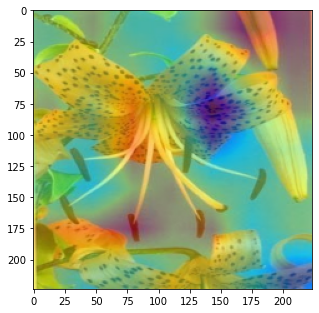

In [102]:
draw_cam(486)

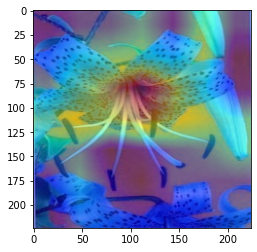

In [103]:
cascade(486)